In [11]:
from datasets import load_dataset
import numpy as np
from dialogue2graph.pipelines.core.graph import Graph

In [3]:
dataset = load_dataset("DeepPavlov/d2g_generated_augmented", token=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['graph', 'topic', 'dialogues', 'augmented_dialogues'],
        num_rows: 376
    })
})

# Part 1

- |{dialog+aug_dialog}|= N ~ G1

- |{paths}|= N ~ G1


G1


p1 > {selected_p}

{paths - 1} -> p2 - p1 = 4

{paths - 1} -> p3 - p1 = 2

{paths - 1} -> p4 - p1 = 10 <<<(max_new_elements)

{paths - 1} -> p5 - p1 = 1


p4 > {selected_p}

selected_p = p1 + p4

{paths - 2} -> p2 - (p1 + p4) = 0

{paths - 2} -> p3 - (p1 + p4) = 1 <<<(max_new_elements)

{paths - 2} -> p5 - (p1 + p4) = 0


p3 > {selected_p}

selected_p = p1 + p4 + p3

{paths - 2} -> p2 - (p1 + p4 +p3) = 0

{paths - 2} -> p5 - (p1 + p4 +p3) = 0

## Functions

In [4]:
def get_start_dialogue(augmented_dialogues):
    max_len = 0
    idx_to_choose_from = []
    for aug_dia in augmented_dialogues:
        if len(aug_dia['messages']) >= max_len:
            max_len = len(aug_dia['messages'])

    for i, aug_dia in enumerate(augmented_dialogues):
        if len(aug_dia['messages']) == max_len:
            idx_to_choose_from.append(i)

    if len(idx_to_choose_from) == 1:
        idx = idx_to_choose_from[0]
    else:
        idx = np.random.choice(idx_to_choose_from)
    
    return idx, augmented_dialogues[idx]

In [5]:
def add_elements_to_paths(start_dialogue, graph):
    # add id to each edge
    for edge in graph['edges']:
        edge_id = str(edge['source']) + '_' + str(edge['target'])
        edge['id'] = edge_id

    paths = {}
    paths['nodes'] = []; paths['edges'] = []

    for turn in start_dialogue['messages']:
        if turn['participant'] == 'assistant':
            key = 'nodes'
        elif turn['participant'] == 'user':
            key = 'edges'

        for element in graph[key]:
            if turn['text'] in element['utterances']:
                paths[key].append(element['id'])
        
    paths['nodes'] = set(paths['nodes'])
    paths['edges'] = set(paths['edges'])
                
    return paths

In [6]:
def count_new_elements(paths, new_paths):
    new_nodes = new_paths['nodes'].difference(paths['nodes'])
    new_edges = new_paths['edges'].difference(paths['edges'])
    new_elements = len(new_nodes) + len(new_edges)
    return new_elements

In [7]:
def get_max_new_elements(augmented_dialogues, added_idx, graph, paths):
    all_new_elements_per_dia = []
    all_paths_per_dia = []
    max_new_elements = 0

    for i, aug_dia in enumerate(augmented_dialogues):
        if i in added_idx:
            continue
        else:
            new_paths = add_elements_to_paths(aug_dia, graph)
            all_paths_per_dia.append((i, new_paths))

            new_elements = count_new_elements(paths, new_paths)        
            all_new_elements_per_dia.append((i, new_elements)) 

            if new_elements >= max_new_elements:
                max_new_elements = new_elements
    
    return all_new_elements_per_dia, all_paths_per_dia, max_new_elements

In [8]:
def get_idx_and_paths_to_add(added_idx, all_new_elements_per_dia, all_paths_per_dia, max_new_elements):
    if max_new_elements == 0:
        return (None, f'no new elements in remaining dialogues')
    
    idx_to_choose_from = []
        
    for i, count in all_new_elements_per_dia:
        if i in added_idx:
            continue
        else:
            if count == max_new_elements:
                idx_to_choose_from.append(i)
    
    if len(idx_to_choose_from) == 1:
        idx_to_add = idx_to_choose_from[0]
    else:
        idx_to_add = np.random.choice(idx_to_choose_from)

    for i, new_paths in all_paths_per_dia:
        if i == idx_to_add:
            paths_to_add = new_paths
                
    return idx_to_add, paths_to_add

In [9]:
def add_new_elements_to_paths(paths, new_elements):
    paths['nodes'] = paths['nodes'].union(new_elements['nodes'])
    paths['edges'] = paths['edges'].union(new_elements['edges'])
    return paths

## Testing

In [10]:
example = dataset['train'][1]
graph = example['graph']
augmented_dialogues = example['dialogues']
len(augmented_dialogues)

12

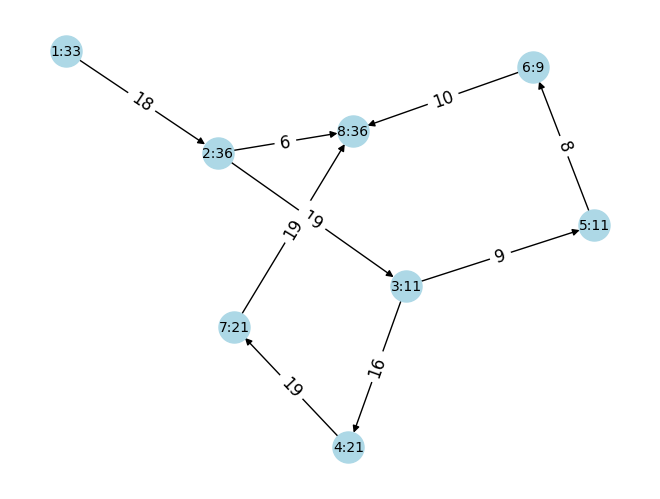

In [12]:
Graph(graph).visualise_short('')

In [27]:
start_idx, start_dia = get_start_dialogue(augmented_dialogues)
start_idx, len(start_dia['messages'])

(6, 11)

In [28]:
paths = add_elements_to_paths(start_dia, graph)
len(paths['nodes']), len(paths['edges'])

(6, 5)

In [29]:
paths

{'nodes': {1, 2, 3, 4, 7, 8}, 'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}

round 1

In [30]:
added_idx = []
added_idx.append(start_idx)

all_new_elements_per_dia, all_paths_per_dia, max_new_elements = get_max_new_elements(augmented_dialogues, added_idx, graph, paths)
all_new_elements_per_dia, all_paths_per_dia, max_new_elements

([(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (7, 5),
  (8, 5),
  (9, 5),
  (10, 1),
  (11, 1)],
 [(0,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (1,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (2,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (3,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (4,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (5,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (7,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (8,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (9,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (10, {'nodes': {1, 2, 8}, 'edges': {'1_2', '2_8'}}),
  (11, {'node

In [31]:
idx_to_add, paths_to_add = get_idx_and_paths_to_add(added_idx, all_new_elements_per_dia, all_paths_per_dia, max_new_elements)
idx_to_add, paths_to_add

(7,
 {'nodes': {1, 2, 3, 5, 6, 8}, 'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}})

In [32]:
added_idx.append(idx_to_add)
paths = add_new_elements_to_paths(paths, paths_to_add)
added_idx, paths

([6, 7],
 {'nodes': {1, 2, 3, 4, 5, 6, 7, 8},
  'edges': {'1_2', '2_3', '3_4', '3_5', '4_7', '5_6', '6_8', '7_8'}})

2 round

In [33]:
all_new_elements_per_dia, all_paths_per_dia, max_new_elements = get_max_new_elements(augmented_dialogues, added_idx, graph, paths)
all_new_elements_per_dia, all_paths_per_dia, max_new_elements

([(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (8, 0),
  (9, 0),
  (10, 1),
  (11, 1)],
 [(0,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (1,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (2,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (3,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (4,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (5,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (8,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (9,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (10, {'nodes': {1, 2, 8}, 'edges': {'1_2', '2_8'}}),
  (11, {'nodes': {1, 2, 8}, 'edges': {'1_2', '2_8'}})],
 1)

In [34]:
idx_to_add, paths_to_add = get_idx_and_paths_to_add(added_idx, all_new_elements_per_dia, all_paths_per_dia, max_new_elements)
idx_to_add, paths_to_add

(11, {'nodes': {1, 2, 8}, 'edges': {'1_2', '2_8'}})

In [35]:
added_idx.append(idx_to_add)
paths = add_new_elements_to_paths(paths, paths_to_add)
added_idx, paths

([6, 7, 11],
 {'nodes': {1, 2, 3, 4, 5, 6, 7, 8},
  'edges': {'1_2', '2_3', '2_8', '3_4', '3_5', '4_7', '5_6', '6_8', '7_8'}})

round 3

In [36]:
all_new_elements_per_dia, all_paths_per_dia, max_new_elements = get_max_new_elements(augmented_dialogues, added_idx, graph, paths)
all_new_elements_per_dia, all_paths_per_dia, max_new_elements

([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (8, 0), (9, 0), (10, 0)],
 [(0,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (1,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (2,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (3,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (4,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (5,
   {'nodes': {1, 2, 3, 4, 7, 8},
    'edges': {'1_2', '2_3', '3_4', '4_7', '7_8'}}),
  (8,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (9,
   {'nodes': {1, 2, 3, 5, 6, 8},
    'edges': {'1_2', '2_3', '3_5', '5_6', '6_8'}}),
  (10, {'nodes': {1, 2, 8}, 'edges': {'1_2', '2_8'}})],
 0)

In [37]:
idx_to_add, paths_to_add = get_idx_and_paths_to_add(added_idx, all_new_elements_per_dia, all_paths_per_dia, max_new_elements)
idx_to_add, paths_to_add

(None, 'no new elements in remaining dialogues')

### whole algorithm:

In [47]:
start_idx, start_dia = get_start_dialogue(augmented_dialogues)
paths = add_elements_to_paths(start_dia, graph)
print(paths)

added_idx = []
added_idx.append(start_idx)
iters = 0
while iters < 100:
    all_new_elements_per_dia, all_paths_per_dia, max_new_elements = get_max_new_elements(
        augmented_dialogues, added_idx, graph, paths
        )
    idx_to_add, paths_to_add = get_idx_and_paths_to_add(
        added_idx, all_new_elements_per_dia, all_paths_per_dia, max_new_elements
        )
    if paths_to_add == 'no new elements in remaining dialogues':
        break
    else:
        added_idx.append(idx_to_add)
        paths = add_new_elements_to_paths(paths, paths_to_add)
        iters += 1
added_idx, paths

{'nodes': {1, 2, 3, 4, 7, 8}, 'edges': {'3_4', '1_2', '2_3', '4_7', '7_8'}}


([6, 8, 10],
 {'nodes': {1, 2, 3, 4, 5, 6, 7, 8},
  'edges': {'1_2', '2_3', '2_8', '3_4', '3_5', '4_7', '5_6', '6_8', '7_8'}})

It means we need only 3 dialogues out of 12 to fully cover the graph.